# Clustering and Analysis of Solar Specta

## Import all the necesssary libraries

In [2]:
import pandas as pd
import numpy as np
import torch
import glob
import os
from torch.utils.data import TensorDataset, DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
import seaborn as sns
from scipy.spatial.distance import cdist
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt
import scipy.ndimage
from itertools import product
from pvlib import spectrum, solarposition, irradiance, atmosphere
import pvlib


## Sliding Windows Approach
When working with time series, it is common practise to average measurements across, often overlapping, windows,in order to denoise the data and to stabilize the training. Here, we average measurements of 5 minutes with a stride of 2, but those hyperparameters can be adjusted. 

Loading: dat/train1/tc_2018-01-01_full_day.csv


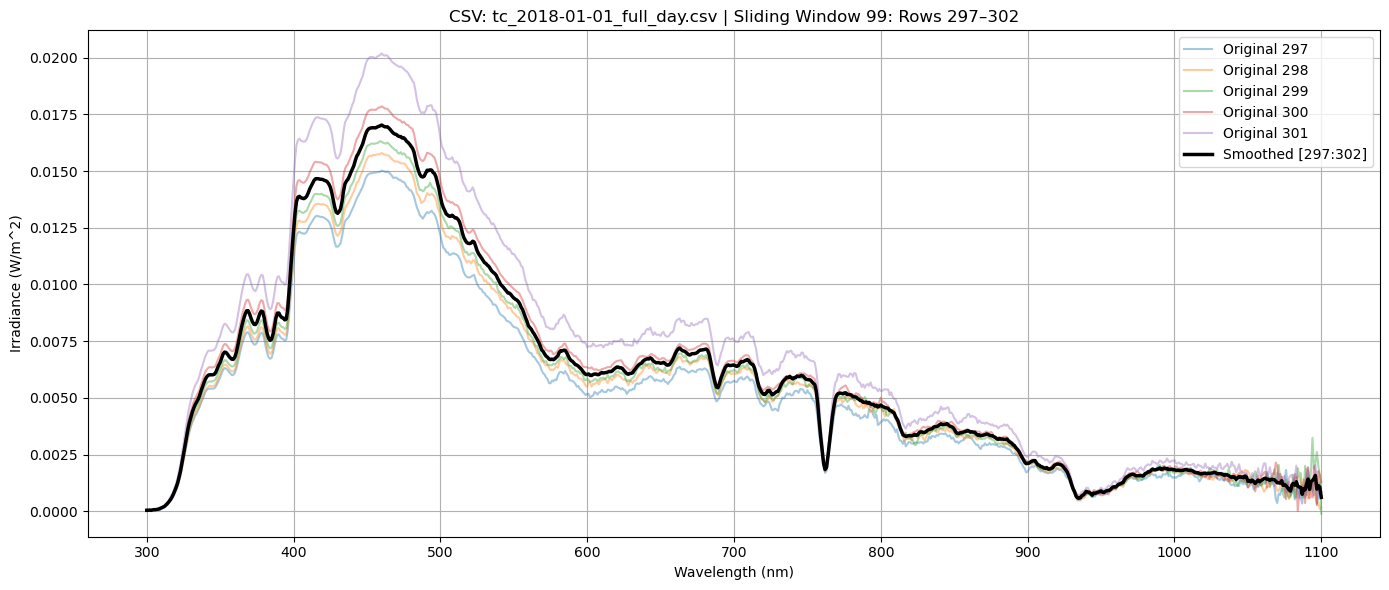

[-20.43   3.62  -8.54 ...  -2.89  -4.25  29.32]


In [5]:

def sliding_window_average(tensor, window_size=5, stride=2):
    N, D = tensor.shape
    smoothed = []
    for start in range(0, N - window_size + 1, stride):
        window = tensor[start:start + window_size]
        avg = window.mean(dim=0)
        smoothed.append(avg)
    return torch.stack(smoothed)

# Load a single CSV from dat/train1
csv_file = sorted(glob.glob('dat/train1/*.csv'))[0]  # Change the [0] to another file index to load another day
print(f"Loading: {csv_file}")

# Load only a slice of the file for speed
max_rows = 8000
df = pd.read_csv(csv_file, nrows=max_rows)

# Drop datetime column and convert to tensor
datetime_col = 'dt_UTC01_NoDLS'
if datetime_col in df.columns:
    df = df.drop(columns=[datetime_col])
data_tensor = torch.tensor(df.values, dtype=torch.float32)/1000

# Windowing parameters -- Adjust to demonstrate
window_index = 99
window_size = 5
stride = 3

# Slicing
start = window_index * stride
end = start + window_size
original_window = data_tensor[start:end]

# Apply smoothing
smoothed_tensor = sliding_window_average(data_tensor, window_size=window_size, stride=stride)
smoothed_window = smoothed_tensor[window_index]

wavelengths = torch.linspace(300, 1100, data_tensor.shape[1]).numpy()

# Plot
plt.figure(figsize=(14, 6))
for i in range(original_window.shape[0]):
    plt.plot(wavelengths, original_window[i].numpy(), alpha=0.4, label=f'Original {start+i}')
plt.plot(wavelengths, smoothed_window.numpy(), color='black', linewidth=2.5, label=f'Smoothed [{start}:{end}]')
plt.title(f"CSV: {os.path.basename(csv_file)} | Sliding Window {window_index}: Rows {start}–{end}")
plt.xlabel("Wavelength (nm)")
plt.ylabel("Irradiance (W/m^2)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

broadband_irradiance = np.trapz(df.values, x=df.columns.astype(float), axis=1)
broadband_irradiance = np.sum(df.values, axis=1)
print(broadband_irradiance)


## Data Preparation
Apart from implying sliding windows as mentioned above, only data with a total broadband irradiance of more than 25 W/m^2 are considered. 

In [2]:



def sliding_window_daywise(df, datetime_col, window_size=5, stride=3):
    df = df.copy()
    df[datetime_col] = pd.to_datetime(df[datetime_col])
    df = df.sort_values(by=datetime_col)
    df.set_index(datetime_col, inplace=True)

    result_rows = []

    for day, day_df in df.groupby(df.index.date):
        timestamps = day_df.index.to_list()
        values = day_df.values
        if len(values) < window_size:
            continue
        for start in range(0, len(values) - window_size + 1, stride):
            window = values[start:start + window_size]
            avg = window.mean(axis=0)
            result_rows.append(avg)

    smoothed_df = pd.DataFrame(result_rows)
    return smoothed_df


def load_or_preprocess(directory_path, cache_path,
                                sum_threshold=50,  min_allowed_value=-0.1,
                                datetime_col='dt_UTC01_NoDLS', window_size=5, stride=3, max_val=4):

    if os.path.exists(cache_path):
        print(f" Loading cached tensor from {cache_path}")
        cached = torch.load(cache_path)
        return cached['tensor_windowed'], cached['tensor_raw'], cached['raw_df'], cached['kept_timestamps']

    print(f"Preprocessing CSVs in {directory_path} ...")
    csv_files = glob.glob(os.path.join(directory_path, '*.csv'))
    tensors_windowed = []
    raw_rows = []
    kept_timestamps = []

    total_initial = 0
    total_final = 0

       # inside loop:
    for fp in csv_files:
        try:
            df = pd.read_csv(fp)
            if datetime_col not in df.columns:
                print(f"Skipping {fp}: missing datetime column '{datetime_col}'")
                continue

            df[datetime_col] = pd.to_datetime(df[datetime_col], errors='coerce')
            df = df.dropna(subset=[datetime_col])

            total_initial += len(df)

            # Filtering
            non_time_df = df.drop(columns=[datetime_col])
            mask = (
                (non_time_df.sum(axis=1) >= sum_threshold) &
                (non_time_df >= min_allowed_value).all(axis=1) &
                (non_time_df.max(axis=1) >= max_val)
            )
            filtered_df = df[mask]
            if filtered_df.empty:
                continue

            filtered_df = filtered_df.sort_values(datetime_col)

            kept_timestamps.append(filtered_df[datetime_col].values)
            raw_rows.append(filtered_df)

            # Sliding window
            smoothed_df = sliding_window_daywise(filtered_df, datetime_col=datetime_col,
                                                window_size=window_size, stride=stride)
            if smoothed_df.empty:
                continue
            smoothed_df[smoothed_df < 0] = 0
            t = torch.tensor(smoothed_df.values, dtype=torch.float32)
            tensors_windowed.append(t)

            total_final += len(smoothed_df)

        except Exception as e:
            print(f"Skipping {fp}: {e}")


    if not tensors_windowed:
        raise RuntimeError(f"No data found in {directory_path} after filtering.")
    
 
    # After loop:
    kept_timestamps = np.concatenate(kept_timestamps)


    tensor_windowed = torch.cat(tensors_windowed, dim=0)
    raw_df = pd.concat(raw_rows).reset_index(drop=True)
    # Set negatives to zero in raw_df
    raw_df.iloc[:, raw_df.columns != datetime_col] = raw_df.drop(columns=[datetime_col]).clip(lower=0).values

    tensor_raw = torch.tensor(raw_df.drop(columns=[datetime_col]).values, dtype=torch.float32)

    os.makedirs(os.path.dirname(cache_path), exist_ok=True)
    torch.save({
        'tensor_windowed': tensor_windowed,
        'tensor_raw': tensor_raw,
        'raw_df': raw_df,
        'kept_timestamps': kept_timestamps
    }, cache_path)

    print(f"Data points before filtering: {total_initial}")
    print(f"Data points after filtering:  {total_final}")
    print(f"Preprocessed and saved to {cache_path}, shape = {tensor_windowed.shape}")

    return tensor_windowed, tensor_raw, raw_df, kept_timestamps

# train_tensor1, train_tensor_raw1, train_df1, train_kept1 = load_or_preprocess('dat/train1', 'cached/train1.pt', sum_threshold=25000)
# train_tensor2, train_tensor_raw2, train_df2, train_kept2 = load_or_preprocess('dat/train2', 'cached/train2.pt', sum_threshold=25000)
# val_tensor, val_tensor_raw, val_df, val_kept     = load_or_preprocess('dat/val',   'cached/val.pt',   sum_threshold=25000)
test_tensor, test_tensor_raw, test_df, test_kept   = load_or_preprocess('dat/test',  'cached/test.pt',  sum_threshold=25000)





 Loading cached tensor from cached/test.pt


/tmp/ipykernel_5419/3832838205.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cached = torch.load(cache_path)


In [5]:
test_df

,dt_UTC01_NoDLS,300.0,301.0,302.0,303.0,304.0,305.0,306.0,307.0,308.0,...,1091.0,1092.0,1093.0,1094.0,1095.0,1096.0,1097.0,1098.0,1099.0,1100.0
0,2024-12-26 10:50:00,0.16,0.18,0.20,0.27,0.40,0.52,0.67,0.88,1.18,...,14.69,14.31,14.21,13.97,12.99,11.14,8.99,8.27,7.50,7.66
1,2024-12-26 10:51:00,0.13,0.14,0.18,0.26,0.36,0.50,0.68,0.94,1.23,...,14.90,15.96,15.77,13.61,12.54,12.04,11.77,9.72,7.67,8.03
2,2024-12-26 10:52:00,0.16,0.17,0.29,0.32,0.39,0.54,0.70,0.88,1.21,...,14.37,14.22,13.53,12.33,12.14,12.20,12.12,11.02,11.05,10.08
3,2024-12-26 10:53:00,0.23,0.24,0.26,0.32,0.41,0.57,0.73,0.93,1.27,...,14.61,13.50,13.11,13.52,15.06,11.91,13.26,16.79,14.92,13.61
4,2024-12-26 10:54:00,0.20,0.21,0.29,0.37,0.47,0.56,0.69,0.97,1.29,...,15.14,11.46,11.61,13.15,11.25,10.76,10.26,12.78,13.20,9.31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202644,2024-12-08 14:53:00,0.00,0.03,0.08,0.09,0.13,0.23,0.38,0.50,0.59,...,14.82,16.60,17.20,19.44,11.61,15.29,19.60,14.08,14.05,6.89
202645,2024-12-08 14:54:00,0.03,0.00,0.11,0.21,0.15,0.26,0.39,0.54,0.71,...,10.01,11.76,10.39,13.08,11.77,8.60,15.89,12.09,10.75,8.97
202646,2024-12-08 14:55:00,0.00,0.02,0.06,0.08,0.24,0.32,0.37,0.50,0.67,...,19.67,13.01,16.48,15.88,10.96,16.91,13.81,15.54,15.79,10.70
202647,2024-12-08 14:56:00,0.05,0.14,0.28,0.19,0.24,0.31,0.29,0.52,0.60,...,12.10,10.97,9.65,17.32,12.59,10.09,14.00,12.56,16.13,10.92


As global horizontal irradiance data come in units of W/m^2 by μm, we are converting in the more common W/m^2 by nm.

In [3]:
# train_tensor1= train_tensor1/1000
# train_tensor2 = train_tensor2/1000
# val_tensor = val_tensor/1000
test_tensor = test_tensor/1000


In [4]:
# train_tensor_raw_1 = train_tensor_raw1/1000
# train_tensor_raw_2 = train_tensor_raw2/1000
# val_tensor_raw = val_tensor_raw/1000
test_tensor_raw = test_tensor_raw/1000


In [5]:
def merge_and_filter_new_folder(folder_path, kept_timestamps, time_col='Time'):
    """
    Merges all CSVs in `folder_path` on the `time_col` column,
    then keeps only rows with timestamps in `kept_timestamps`.

    Parameters:
    - folder_path: Path to the 'New' folder
    - kept_timestamps: List or set of pd.Timestamp to keep
    - time_col: The column to join on and to filter by (default: 'Time')

    Returns:
    - merged_df: Filtered merged DataFrame
    """

    csv_files = glob.glob(os.path.join(folder_path, '*.csv'))
    merged_df = None

    for file in csv_files:
        df = pd.read_csv(file)

        if time_col not in df.columns:
            print(f"Skipping {file}: missing '{time_col}' column")
            continue

        df[time_col] = pd.to_datetime(df[time_col], errors='coerce')
        df = df.dropna(subset=[time_col])

        if merged_df is None:
            merged_df = df
        else:
            merged_df = pd.merge(merged_df, df, on=time_col, how='inner')

    if merged_df is None:
        raise RuntimeError("No valid CSVs found in the folder.")

    before_rows = len(merged_df)

    # Keep only rows with time in kept_timestamps
    merged_df = merged_df[merged_df[time_col].isin(kept_timestamps)]

    after_rows = len(merged_df)
    print(f"Retained {after_rows} rows based on kept timestamps (from {before_rows} total).")

    return merged_df


In [6]:
cleaned_merged_dftest = merge_and_filter_new_folder('New', test_kept)

Retained 183778 rows based on kept timestamps (from 486162 total).


In [9]:
# First cast both to datetime (if not already)
kept_ts_index = pd.to_datetime(pd.Series(test_kept))
merged_ts_index = pd.to_datetime(cleaned_merged_dftest['Time'])

# Find intersection
common_ts = pd.Series(sorted(set(kept_ts_index) & set(merged_ts_index)))

# Filter merged dataframe accordingly
cleaned_merged_dftest = cleaned_merged_dftest[cleaned_merged_dftest['Time'].isin(common_ts)].reset_index(drop=True)

# Filter raw_df accordingly (if you want perfect alignment on both sides)
filtered_raw_df = test_df[test_df['dt_UTC01_NoDLS'].isin(common_ts)].reset_index(drop=True)

# Sanity check:
assert len(cleaned_merged_dftest) == len(filtered_raw_df)


In [25]:
print(f"train_tensor1.shape: {train_tensor1.shape}")
print(f"train_tensor2.shape: {train_tensor2.shape}")
print(f"test_tensor.shape: {test_tensor.shape}")
print(f"val_tensor.shape: {val_tensor.shape}")

train_tensor1.shape: torch.Size([73166, 801])
train_tensor2.shape: torch.Size([72663, 801])
test_tensor.shape: torch.Size([67203, 801])
val_tensor.shape: torch.Size([67203, 801])


## Deep Autoencoder Model
Below is defined the Deep Autoencoder MLP model, which will be used later to reduce the dimensions of the spectra in order to use the low-dimensional data for clustering.

In [7]:
class DAE(nn.Module):
    def __init__(self, input_dim):
        super(DAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 600),
            nn.BatchNorm1d(600),
            nn.ReLU(),

            nn.Linear(600, 400),
            nn.BatchNorm1d(400),
            nn.ReLU(),

            nn.Linear(400, 200),
            nn.BatchNorm1d(200),
            nn.ReLU(),

            nn.Linear(200, 6)
        )

        self.decoder = nn.Sequential(
            nn.Linear(6, 200),
            nn.BatchNorm1d(200),
            nn.ReLU(),

            nn.Linear(200, 400),
            nn.BatchNorm1d(400),
            nn.ReLU(),

            nn.Linear(400, 600),
            nn.BatchNorm1d(600),
            nn.ReLU(),

            nn.Linear(600, input_dim)
        )

        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


## Train the model
Do not run the following cell, unless necessary. Instead load the model from the cell later imn the notebook.
Below is a grid search implemented to come up with the best performing model on the dataset. The dataset is defined as follows:
Training set: Full years 2018, 2019, 24 May 2023- 31 Dec 2023 & 01 Jan 2025- 14 May 2025 in order to capture the characteristics of a full year
Validation set: Full year 2024
The best performing model on the validation set reaches a RMS reconstruction loss of 4x10^-5. 

In [37]:
# Set up device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

train_tensor = torch.cat([train_tensor1, train_tensor2, val_tensor], dim=0)
val_tensor = test_tensor

# # Normalize
# eps = 1e-8
# # train_min = test_tensor.min(dim=1, keepdim=True).values
# train_max = train_tensor.max(dim=1, keepdim=True).values
# # train_tensor_norm = (test_tensor - train_min) / (train_max - train_min + eps)
# train_tensor_norm = (train_tensor) / (train_max  + eps)

# # val_min = val_tensor.min(dim=1, keepdim=True).values
# val_max = val_tensor.max(dim=1, keepdim=True).values
# # val_tensor_norm = (val_tensor - val_min) / (val_max - val_min + eps)
# val_tensor_norm = (val_tensor) / (val_max + eps)

train_tensor_norm = train_tensor
val_tensor_norm = val_tensor

# Grid search hyperparameters
learning_rates = [0.001, 0.0015, 0.00077, 0.01]
batch_sizes = [128, 256, 512, 1024]
n_epochs = 100

# Tracking best model
best_val_loss = float('inf')
best_model_path = "best_model.pth"
best_hparams = None

for lr, batch_size in product(learning_rates, batch_sizes):
    print(f"\n Testing lr={lr}, batch_size={batch_size}")

    # Create fresh model
    model = DAE(input_dim=test_tensor.shape[1]).to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)
    criterion = nn.MSELoss()

    # Dataloaders
    train_dataset = TensorDataset(train_tensor_norm)
    val_dataset = TensorDataset(val_tensor_norm)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    train_losses, val_losses = [], []

    for epoch in range(n_epochs):
        model.train()
        total_train_loss = 0.0
        total_samples = 0

        for batch in train_loader:
            x = batch[0].to(device)
            optimizer.zero_grad()
            recon = model(x)
            loss = criterion(recon, x)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item() * x.size(0)
            total_samples += x.size(0)

        avg_train_loss = total_train_loss / total_samples

        # Validation
        model.eval()
        total_val_loss = 0.0
        val_samples = 0
        with torch.no_grad():
            for batch in val_loader:
                x = batch[0].to(device)
                recon = model(x)
                loss = criterion(recon, x)
                total_val_loss += loss.item() * x.size(0)
                val_samples += x.size(0)

        avg_val_loss = total_val_loss / val_samples
        scheduler.step(avg_val_loss)

        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)

        # Save best model across all hyperparameter settings
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), best_model_path)
            best_hparams = {'learning_rate': lr, 'batch_size': batch_size}
            print(f"New best model at epoch {epoch+1} with val_loss = {avg_val_loss:.6f} | lr={lr}, batch_size={batch_size}")

        print(f"Epoch {epoch+1:02d}/{n_epochs} - Train Loss: {avg_train_loss:.6f} | Val Loss: {avg_val_loss:.6f}")

# Final results
print("\nBest hyperparameters:")
print(f"Learning rate: {best_hparams['learning_rate']}")
print(f"Batch size: {best_hparams['batch_size']}")
print(f"Best validation loss: {best_val_loss:.6f}")


Using device: cuda

 Testing lr=0.001, batch_size=128
New best model at epoch 1 with val_loss = 0.001234 | lr=0.001, batch_size=128
Epoch 01/100 - Train Loss: 0.005226 | Val Loss: 0.001234
New best model at epoch 2 with val_loss = 0.000464 | lr=0.001, batch_size=128
Epoch 02/100 - Train Loss: 0.002012 | Val Loss: 0.000464
Epoch 03/100 - Train Loss: 0.001467 | Val Loss: 0.001873
Epoch 04/100 - Train Loss: 0.001176 | Val Loss: 0.000488
Epoch 05/100 - Train Loss: 0.001129 | Val Loss: 0.000606
New best model at epoch 6 with val_loss = 0.000190 | lr=0.001, batch_size=128
Epoch 06/100 - Train Loss: 0.001038 | Val Loss: 0.000190
Epoch 07/100 - Train Loss: 0.000885 | Val Loss: 0.000555
Epoch 08/100 - Train Loss: 0.000815 | Val Loss: 0.001218
Epoch 09/100 - Train Loss: 0.000791 | Val Loss: 0.002362
Epoch 10/100 - Train Loss: 0.000713 | Val Loss: 0.000341
Epoch 11/100 - Train Loss: 0.000748 | Val Loss: 0.000484
New best model at epoch 12 with val_loss = 0.000113 | lr=0.001, batch_size=128
Epoch 

## Load the model

In [19]:
device='cuda'
model = DAE(input_dim=801)
model.load_state_dict(torch.load("best_model.pth", map_location=device))
model.to(device)
model.eval()

/tmp/ipykernel_5419/589126015.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pth", map_location=device))


DAE(
  (encoder): Sequential(
    (0): Linear(in_features=801, out_features=600, bias=True)
    (1): BatchNorm1d(600, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=600, out_features=400, bias=True)
    (4): BatchNorm1d(400, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=400, out_features=200, bias=True)
    (7): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Linear(in_features=200, out_features=6, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=6, out_features=200, bias=True)
    (1): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=200, out_features=400, bias=True)
    (4): BatchNorm1d(400, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=400, out_featur

## Code for ploting the original and the reconstructed spectrum

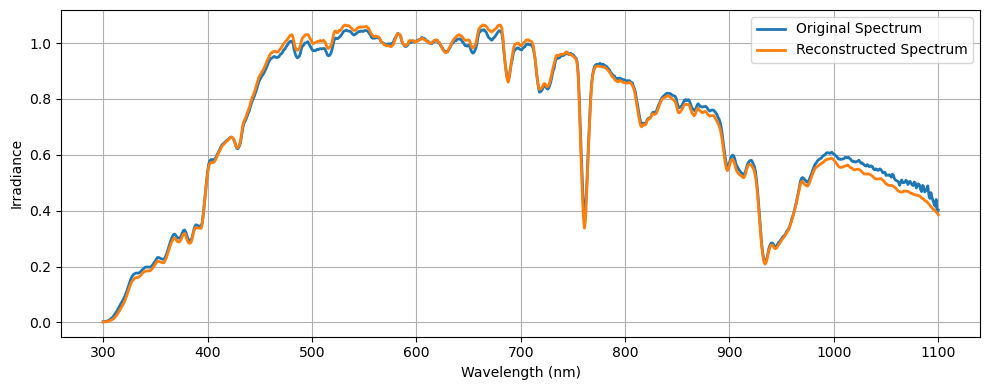

In [13]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# Select one example spectrum from the dataset (e.g., index 0)
idx = 420
original = test_tensor[idx]  
original = original.unsqueeze(0).to(device)  

# Run through DAE to get reconstruction
model.eval()
with torch.no_grad():
    reconstructed = model(original)

# Move both to CPU and convert to numpy
original_np = original.squeeze().cpu().numpy()
reconstructed_np = reconstructed.squeeze().cpu().numpy()

# X-axis: Wavelengths from 300 to 1100 nm
wavelengths = np.linspace(300, 1100, len(original_np))

# Adjust wavelength region 
mask = (wavelengths >= 300) & (wavelengths <= 1100)
wavelengths_zoom = wavelengths[mask]
original_zoom = original_np[mask]
reconstructed_zoom = reconstructed_np[mask]

# Plot
plt.figure(figsize=(10, 4))
plt.plot(wavelengths_zoom, original_zoom, label='Original Spectrum', linewidth=2)
plt.plot(wavelengths_zoom, reconstructed_zoom, label='Reconstructed Spectrum', linewidth=2)
plt.xlabel('Wavelength (nm)')
plt.ylabel('Irradiance')
# plt.title('Zoomed Spectrum: 1000–1100 nm')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



In [138]:
import pandas as pd

# Load the CSV
file_path = 'dat/test/tc_2024-01-01_full_day.csv'
df = pd.read_csv(file_path)

# Keep a copy of the datetime column
if 'dt_UTC01_NoDLS' in df.columns:
    time_column = df['dt_UTC01_NoDLS']
else:
    raise ValueError("dt_UTC01_NoDLS column not found.")

# Drop datetime for processing
df_numeric = df.drop(columns='dt_UTC01_NoDLS')

# Convert to numeric and clean
df_numeric = df_numeric.apply(pd.to_numeric, errors='coerce')
df_numeric = df_numeric.dropna()

# Find first row where sum > 25
row_sums = df_numeric.sum(axis=1)
first_valid_idx = row_sums[row_sums > 100].index[0]

# Get the datetime for that row
timestamp = time_column[first_valid_idx]

print("Timestamp of first valid row (sum > 25):", timestamp)


Timestamp of first valid row (sum > 25): 2024-01-01 08:14:00


# Clustering
Hierarchical Agglomerative Clustering is the algorithm, which is used to cluster the data.

In [14]:

model.eval()
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)

batch_size = 512
test_loader = DataLoader(TensorDataset(test_tensor_raw), batch_size=batch_size)  

all_latents = []

with torch.no_grad():
    for batch in test_loader:
        x = batch[0].to(device)
        latent = model.encoder(x)
        all_latents.append(latent.cpu())

latent_representations = torch.cat(all_latents, dim=0)
print("Latent shape:", latent_representations.shape)


Latent shape: torch.Size([202649, 6])


In [20]:


# Ensure datetime columns are correct
test_df['dt_UTC01_NoDLS'] = pd.to_datetime(test_df['dt_UTC01_NoDLS'])
cleaned_merged_dftest['Time'] = pd.to_datetime(cleaned_merged_dftest['Time'])

# Merge and ALIGN on datetime
aligned_df = pd.merge(
    test_df,
    cleaned_merged_dftest,
    left_on='dt_UTC01_NoDLS',
    right_on='Time',
    how='inner'
).reset_index(drop=True)

# Safety check
assert len(aligned_df) == len(aligned_df['dt_UTC01_NoDLS'])
aligned_tensor = test_tensor_raw[aligned_df.index.to_numpy()]

# Compute latent representations
model.eval()
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)

batch_size = 512
test_loader = DataLoader(TensorDataset(aligned_tensor), batch_size=batch_size)
all_latents = []

with torch.no_grad():
    for batch in test_loader:
        x = batch[0].to(device)
        latent = model.encoder(x)
        all_latents.append(latent.cpu())

latent_representations = torch.cat(all_latents, dim=0).numpy()

#Unified subsampling
sample_size = 20000
sample_indices = np.random.choice(len(aligned_df), size=sample_size, replace=False)

# Subsample everything together
sampled_df = aligned_df.iloc[sample_indices].reset_index(drop=True)
sampled_tensor = aligned_tensor[sample_indices].cpu().numpy() * 1000  # back to W/m²/nm
sampled_latent = latent_representations[sample_indices]



In [15]:


# Convert to numpy
latent_np = latent_representations.numpy()

# Sample once
sample_size = 20000
sample_indices = np.random.choice(latent_np.shape[0], size=sample_size, replace=False)

# Subsample latent representations
sampled_latent = latent_np[sample_indices]


# # Optional: dendrogram visualization (just for fun)
# linked = linkage(sampled_latent, method='ward')
# plt.figure(figsize=(10, 4))
# # dendrogram(linked, orientation='top', distance_sort='descending', show_leaf_counts=True)
# dendrogram(linked,
#            orientation='top',
#            distance_sort='descending',
#            show_leaf_counts=True,
#            labels=np.arange(len(sampled_latent)))

# plt.title("Dendrogram (HAC)")
# plt.xlabel("Sample index")
# plt.ylabel("Distance")
# plt.tight_layout()
# plt.show()

## Elbow Plot
The number of clusters will be defined by the elbow plot below. According to the Within-Cluster Sum of Squares (WCSS), which is a metric used to evaluate the quality of clusters in clustering algorithms, and vewing its decrase, it is decided that the number of clusters will be set toi 5.

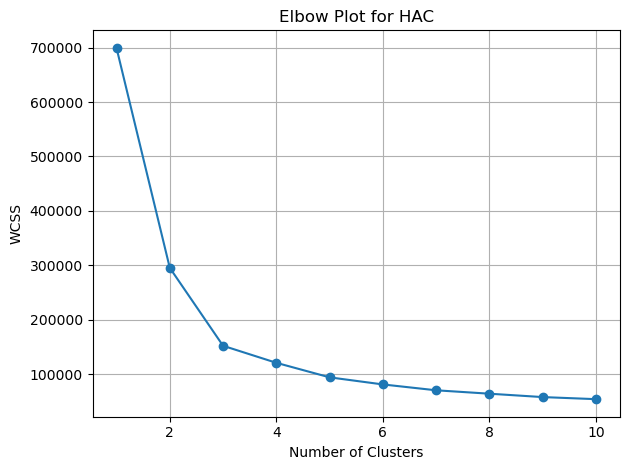

In [16]:

wcss = []
cluster_range = range(1, 11)

for k in cluster_range:
    model = AgglomerativeClustering(n_clusters=k)
    labels = model.fit_predict(sampled_latent)

    # Compute WCSS manually
    wcss_k = 0
    for cluster_id in np.unique(labels):
        cluster_points = sampled_latent[labels == cluster_id]
        centroid = cluster_points.mean(axis=0)
        distances = np.sum((cluster_points - centroid) ** 2)
        wcss_k += distances

    wcss.append(wcss_k)

# Plot WCSS (elbow)
plt.figure()
plt.plot(cluster_range, wcss, marker='o')
plt.title("Elbow Plot for HAC")
plt.xlabel("Number of Clusters")
plt.ylabel("WCSS")
plt.grid(True)
plt.tight_layout()
plt.show()

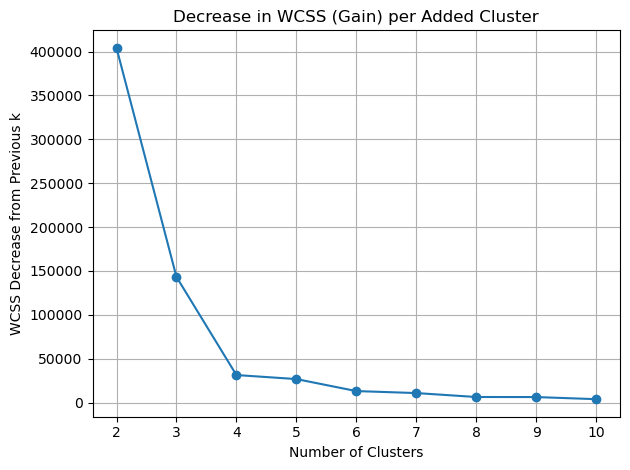

In [17]:
# Compute WCSS decrease
wcss_decrease = np.diff(wcss)  # WCSS[k] - WCSS[k+1] 

# Plot decrease in WCSS
plt.figure()
plt.plot(cluster_range[1:], -wcss_decrease, marker='o')  # negative to flip and show "decrease"
plt.title("Decrease in WCSS (Gain) per Added Cluster")
plt.xlabel("Number of Clusters")
plt.ylabel("WCSS Decrease from Previous k")
plt.grid(True)
plt.tight_layout()
plt.show()


green one is red-shift, because it is lower on the left of the peak amd higher on high wavelength

# Plots with clusters

In [ ]:
from pvlib import spectrum

# 1. Drop datetime column (it’s not spectral data)
df_clean = test_df.drop(columns=['dt_UTC01_NoDLS'])

# 2. Undo μm to nm scaling (if spectra were divided by 1000 during training)
df_clean *= 1000  # Now units are W/m²/nm

# 3. Convert column names to floats (wavelengths in nm)
df_clean.columns = df_clean.columns.astype(float)

# 4. Compute APE using pvlib (column names = wavelengths in nm)
ape_vals = spectrum.average_photon_energy(df_clean)



## Scatter plot of the Average Photon Energy 

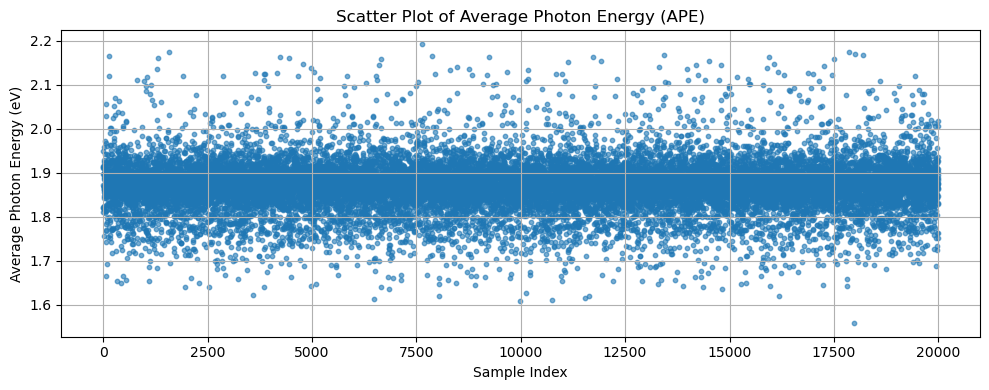

In [17]:
import numpy as np
import matplotlib.pyplot as plt

# 1. Convert APE values to NumPy if necessary
ape_np = ape_vals.cpu().numpy() if hasattr(ape_vals, 'cpu') else np.array(ape_vals)

# 2. Plot APE vs sample index
plt.figure(figsize=(10, 4))
plt.scatter(np.arange(len(ape_np)), ape_np, alpha=0.6, s=10)
plt.xlabel("Sample Index")
plt.ylabel("Average Photon Energy (eV)")
plt.title("Scatter Plot of Average Photon Energy (APE)")
plt.grid(True)
plt.tight_layout()
plt.show()


In [28]:
# 1️⃣ Make sure columns are strings
aligned_df.columns = aligned_df.columns.astype(str)

# 2️⃣ Extract spectral columns (300-1100 nm)
spectral_columns = [
    col for col in aligned_df.columns
    if col.replace('.', '', 1).isdigit() and 300 <= float(col) <= 1100
]

# 3️⃣ Compute GHI from spectra
ghi_from_spectra = aligned_df[spectral_columns].sum(axis=1)/1000

# 4️⃣ Extract the GHI column directly
ghi_column = aligned_df['GHI']

# 5️⃣ Compute mean difference, absolute error, and correlation
diff = ghi_from_spectra - ghi_column

mean_diff = diff.mean()
mean_abs_diff = diff.abs().mean()
correlation = ghi_from_spectra.corr(ghi_column)

# 6️⃣ Print the results
print(f"Mean difference: {mean_diff:.3f} W/m²")
print(f"Mean absolute difference: {mean_abs_diff:.3f} W/m²")
print(f"Pearson correlation: {correlation:.3f}")


Mean difference: 41.970 W/m²
Mean absolute difference: 71.904 W/m²
Pearson correlation: 0.916


In [ ]:

# Make sure column names are strings
aligned_df.columns = aligned_df.columns.astype(str)

# Extract spectral columns from 300-1100 nm
spectral_columns = [
    col for col in aligned_df.columns
    if col.replace('.', '', 1).isdigit() and 300 <= float(col) <= 1100
]

# Create tensor directly from aligned_df
spectra_np = aligned_df[spectral_columns].values.astype(np.float32)
spectra_tensor = torch.tensor(spectra_np)

# Inference: get latent representations
model.eval()
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)

batch_size = 512
test_loader = DataLoader(TensorDataset(spectra_tensor), batch_size=batch_size)
all_latents = []

with torch.no_grad():
    for batch in test_loader:
        x = batch[0].to(device)
        latent = model.encoder(x)
        all_latents.append(latent.cpu())

latent_representations = torch.cat(all_latents, dim=0).numpy()

# Subsample everything consistently
sample_size = 50000
sample_indices = np.random.choice(len(aligned_df), size=sample_size, replace=False)

sampled_df = aligned_df.iloc[sample_indices].reset_index(drop=True)
sampled_spectra = spectra_np[sample_indices]
sampled_latent = latent_representations[sample_indices]

#  Clustering (HAC)
hac = AgglomerativeClustering(n_clusters=4)
cluster_labels = hac.fit_predict(sampled_latent)


# PVLIB clearsky calculation
lat, lon, tz = 51.44623, 5.48505, 'Europe/Amsterdam'
location = pvlib.location.Location(latitude=lat, longitude=lon, tz=tz)

# Properly localize times
times = pd.to_datetime(sampled_df['dt_UTC01_NoDLS'])
times = pd.DatetimeIndex(times)
if times.tz is None:
    times = times.tz_localize(tz)
else:
    times = times.tz_convert(tz)

clearsky = location.get_clearsky(times, model='ineichen')
ghi_clearsky = clearsky['ghi'].reset_index(drop=True)

#Compute GHI from spectra (note: /1000 to get W/m²)
ghi_measured = sampled_spectra.sum(axis=1) / 1000

ghi_measured = sampled_df['GHI']


#  Compute Clear Sky Index (kt) correctly
epsilon = 1e-3
kt = ghi_measured / (ghi_clearsky + epsilon)
kt = kt.clip(lower=0, upper=3).fillna(0)

# APE calculation
wavelengths = np.arange(300, 1101)
h, c, e = 6.62607015e-34, 299792458, 1.602176634e-19
wavelengths_m = wavelengths * 1e-9
photon_energy = h * c / wavelengths_m / e  # eV

spectra_df = pd.DataFrame(sampled_spectra)
numerator = (spectra_df * photon_energy).sum(axis=1)
denominator = spectra_df.sum(axis=1)
ape_vals = numerator / denominator

# Assemble final dataframe
plot_df = pd.DataFrame({
    'APE [eV]': ape_vals,
    'Total Irradiance [W/m²]': denominator/1000,
    'ClearSkyIndex': kt,
    'Cluster': cluster_labels.astype(str),
    'Datetime': sampled_df['dt_UTC01_NoDLS'].astype(str)
})

# Sanity printout:
print("Pipeline finished. Sample summary:")
print(plot_df.describe())

# Final plots:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=plot_df, x='APE [eV]', y='Total Irradiance [W/m²]', hue='Cluster', s=30, alpha=0.7)
plt.title("APE vs Total Irradiance Colored by Cluster")
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
sns.scatterplot(data=plot_df, x='APE [eV]', y='ClearSkyIndex', hue='Cluster', s=30, alpha=0.7)
plt.title("Clear Sky Index vs APE Colored by Cluster")
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
sns.scatterplot(data=plot_df, x='Total Irradiance [W/m²]', y='ClearSkyIndex', hue='Cluster', s=30, alpha=0.7)
plt.title("Clear Sky Index vs Irradiance Colored by Cluster")
plt.grid(True)
plt.show()


# STRIPPLOTS on non-spectral numeric columns

numeric_cols = aligned_df.select_dtypes(include='number').columns
non_spectral_numeric_cols = [col for col in numeric_cols if col not in spectral_columns and col != 'GHI']
non_spectral_numeric_cols = [
    col for col in non_spectral_numeric_cols if not any(t in col.lower() for t in ['time', 'date'])
]

print(f"Found {len(non_spectral_numeric_cols)} non-spectral numeric columns to plot.")

sampled_extra = aligned_df.iloc[sample_indices].reset_index(drop=True)

sampled_extra['Cluster'] = cluster_labels

# Plot stripplots for each feature vs cluster
for col in non_spectral_numeric_cols:
    plt.figure(figsize=(7, 5))
    sns.stripplot(x='Cluster', y=col, data=sampled_extra, jitter=0.3, alpha=0.7)
    plt.title(f'{col} vs Cluster')
    plt.xlabel('Cluster')
    plt.ylabel(col)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# Subset aligned_df with the same sampling as above:
sampled_extra = aligned_df.iloc[sample_indices].reset_index(drop=True)
sampled_extra['Cluster'] = cluster_labels

# Plot boxplots for each feature vs cluster
for col in non_spectral_numeric_cols:
    plt.figure(figsize=(7, 5))
    sns.boxplot(x='Cluster', y=col, data=sampled_extra)
    plt.title(f'{col} vs Cluster (Boxplot)')
    plt.xlabel('Cluster')
    plt.ylabel(col)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


from scipy.spatial.distance import cdist

# Compute representative indices per cluster
representative_indices = []

for cluster_id in np.unique(cluster_labels):
    # Get indices of samples in this cluster (inside the sampled data)
    cluster_idx = np.where(cluster_labels == cluster_id)[0]
    cluster_latents = sampled_latent[cluster_idx]

    # Compute pairwise distances in latent space
    pairwise_dists = cdist(cluster_latents, cluster_latents, metric='euclidean')
    sum_dists = pairwise_dists.sum(axis=1)

    # Find sample with minimum total distance (the centroid)
    rep_idx_within_cluster = np.argmin(sum_dists)
    rep_idx = cluster_idx[rep_idx_within_cluster]
    representative_indices.append(rep_idx)

# Get corresponding spectra and timestamps
rep_spectra = sampled_spectra[representative_indices]   # already in W/m²/nm scale
rep_datetimes = sampled_df.iloc[representative_indices]["dt_UTC01_NoDLS"].astype(str).tolist()

# Plot representative spectra
plt.figure(figsize=(10, 6))
wavelengths = np.arange(300, 1101)


rep_spectra_df = pd.DataFrame(rep_spectra)
rep_numerator = (rep_spectra_df * photon_energy).sum(axis=1)
rep_denominator = rep_spectra_df.sum(axis=1)
rep_ape_vals = rep_numerator / rep_denominator


for i, (spec, dt, ape) in enumerate(zip(rep_spectra, rep_datetimes, rep_ape_vals)):
    plt.plot(wavelengths, spec, label=f'Cluster {i} | {dt} | APE={ape:.3f} eV')

plt.title('Representative Spectra from Each Cluster (with APE and Timestamp)')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Irradiance [W/m²/nm]')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()




In [24]:
# Compute average Clear Sky Index (CSI) per cluster
avg_csi_per_cluster = plot_df.groupby('Cluster')['ClearSkyIndex'].mean()

# Print results
print("Average CSI per cluster:")
print(avg_csi_per_cluster)


Average CSI per cluster:
Cluster
0    0.901790
1    1.112031
2    0.682506
3    1.114076
Name: ClearSkyIndex, dtype: float64


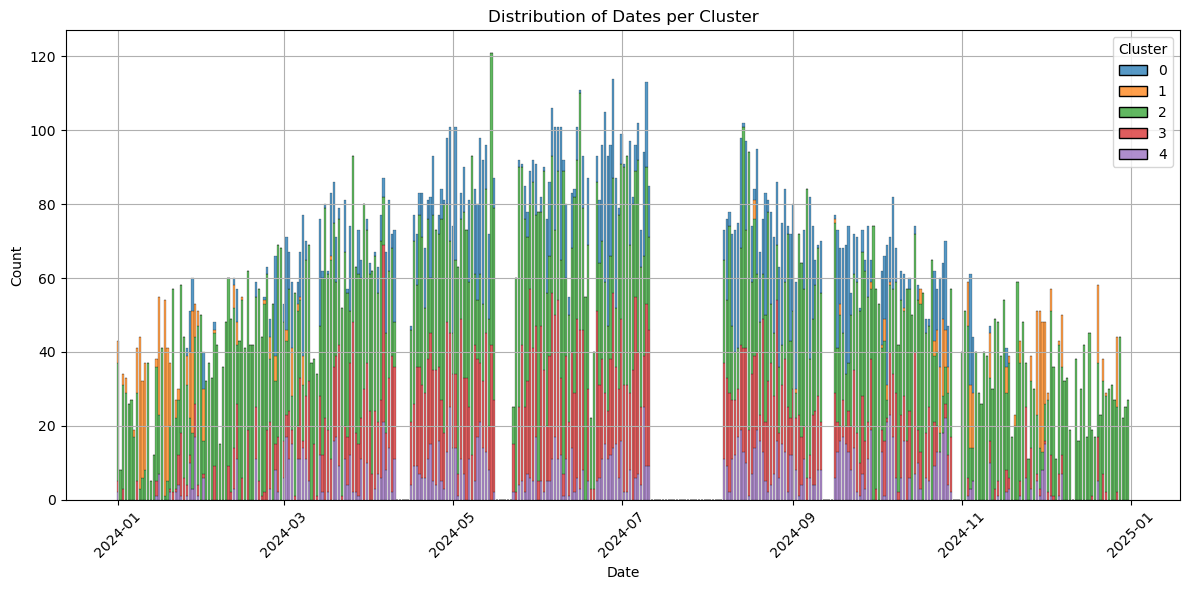

In [67]:
# Extract date information
sampled_df['Date'] = pd.to_datetime(sampled_df['dt_UTC01_NoDLS']).dt.date
sampled_df['Cluster'] = cluster_labels

# Plot: distribution of dates per cluster
plt.figure(figsize=(12, 6))
sns.histplot(data=sampled_df, x='Date', hue='Cluster', multiple='stack', shrink=0.8, palette='tab10')
plt.title("Distribution of Dates per Cluster")
plt.xlabel("Date")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


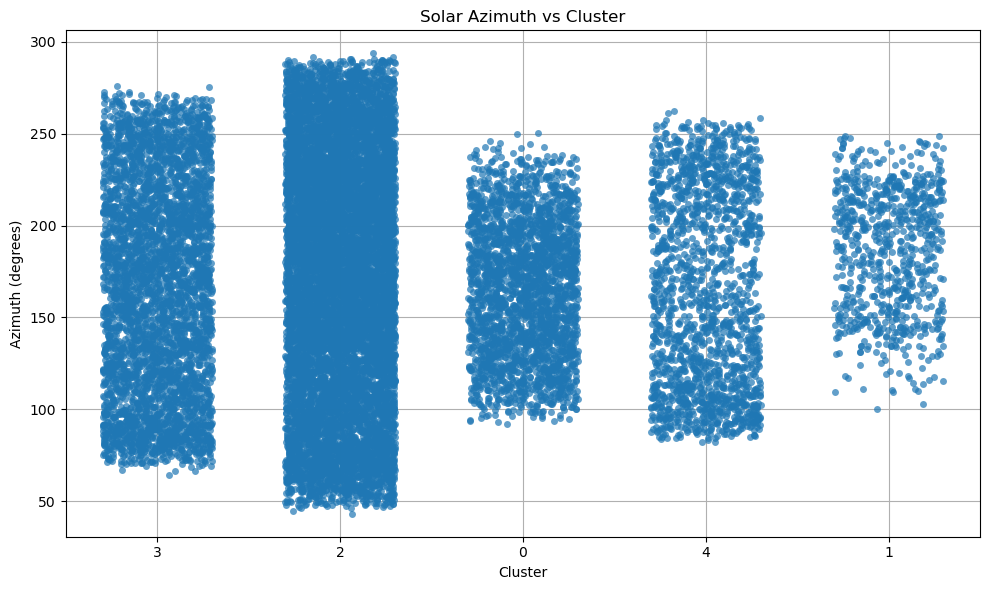

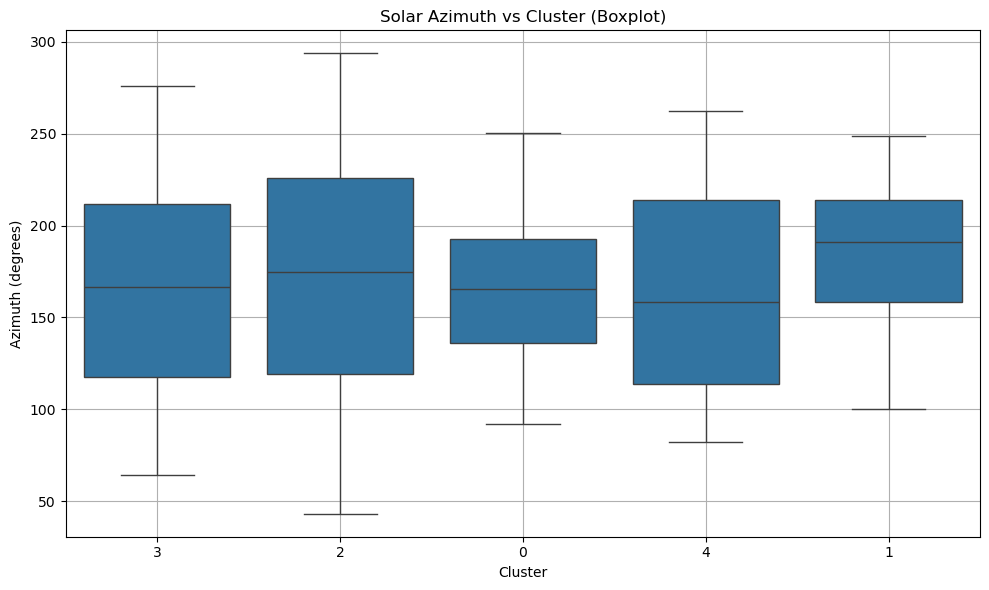

In [68]:
lat, lon, tz = 51.44623, 5.48505, 'Europe/Amsterdam'
location = pvlib.location.Location(latitude=lat, longitude=lon, tz=tz)

times = pd.to_datetime(sampled_df['dt_UTC01_NoDLS'])
times = pd.DatetimeIndex(times)
if times.tz is None:
    times = times.tz_localize(tz)
else:
    times = times.tz_convert(tz)

# calculate solar position
solpos = location.get_solarposition(times)

# extract azimuth
azimuth = solpos['azimuth'].reset_index(drop=True)
# Add to your final dataframe for plotting
plot_df['Azimuth'] = azimuth
plt.figure(figsize=(10, 6))
sns.stripplot(x='Cluster', y='Azimuth', data=plot_df, jitter=0.3, alpha=0.7)
plt.title("Solar Azimuth vs Cluster")
plt.xlabel("Cluster")
plt.ylabel("Azimuth (degrees)")
plt.grid(True)
plt.tight_layout()
plt.show()


plt.figure(figsize=(10, 6))
sns.boxplot(x='Cluster', y='Azimuth', data=plot_df)
plt.title("Solar Azimuth vs Cluster (Boxplot)")
plt.xlabel("Cluster")
plt.ylabel("Azimuth (degrees)")
plt.grid(True)
plt.tight_layout()
plt.show()


In [69]:
# Make sure columns are strings
aligned_df.columns = aligned_df.columns.astype(str)

# Extract spectral columns (300-1100 nm)
spectral_columns = [
    col for col in aligned_df.columns
    if col.replace('.', '', 1).isdigit() and 300 <= float(col) <= 1100
]

# Compute GHI from spectra
ghi_from_spectra = aligned_df[spectral_columns].sum(axis=1)

# Extract the GHI column directly
ghi_column = aligned_df['GHI']

#  
# Compute mean difference, absolute error, and correlation
diff = ghi_from_spectra - ghi_column

mean_diff = diff.mean()
mean_abs_diff = diff.abs().mean()
correlation = ghi_from_spectra.corr(ghi_column)

print(f"Mean difference: {mean_diff:.3f} W/m²")
print(f"Mean absolute difference: {mean_abs_diff:.3f} W/m²")
print(f"Pearson correlation: {correlation:.3f}")


Mean difference: 298546.409 W/m²
Mean absolute difference: 298546.409 W/m²
Pearson correlation: 0.916


Found 801 spectral columns.


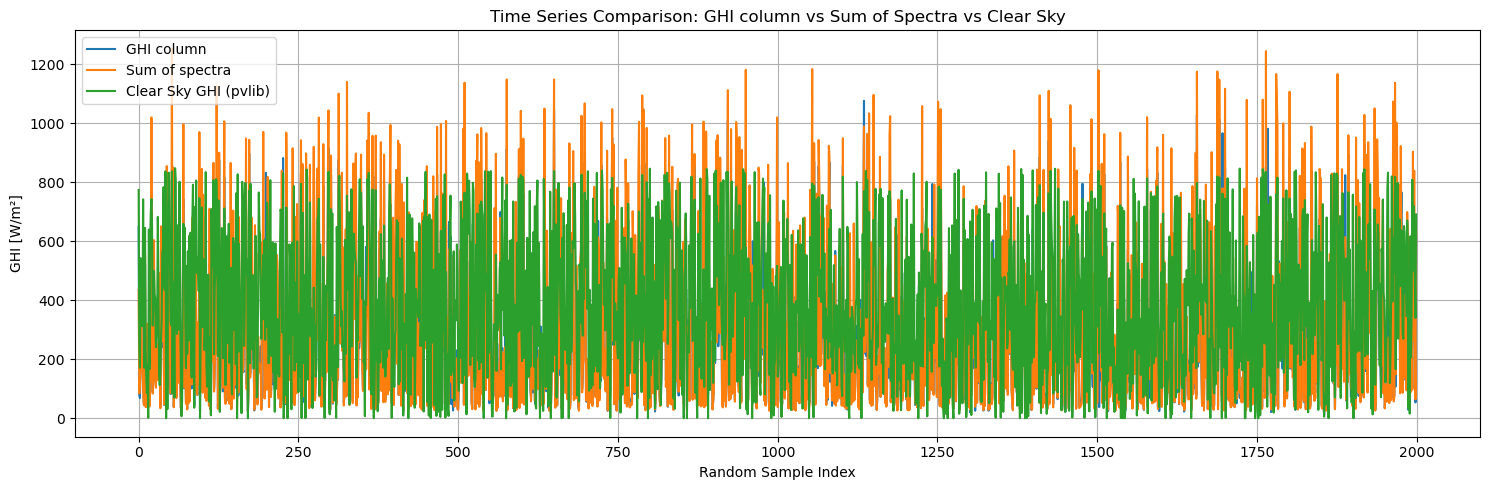

In [70]:
# Ensure column names are strings
aligned_df.columns = aligned_df.columns.astype(str)

# Extract spectral columns
spectral_columns = [
    col for col in aligned_df.columns
    if col.replace('.', '', 1).isdigit() and 300 <= float(col) <= 1100
]

print(f"Found {len(spectral_columns)} spectral columns.")

# Compute GHI from spectrum
ghi_from_spectra = aligned_df[spectral_columns].sum(axis=1) / 1000  # W/m²

# Extract GHI column
ghi_measured = aligned_df['GHI']

# Compute Clear Sky GHI via PVLIB
times = pd.DatetimeIndex(pd.to_datetime(aligned_df['dt_UTC01_NoDLS']))

# localize timezone
if times.tz is None:
    times = times.tz_localize('Europe/Amsterdam')
else:
    times = times.tz_convert('Europe/Amsterdam')

lat, lon = 51.44623, 5.48505
location = pvlib.location.Location(latitude=lat, longitude=lon, tz='Europe/Amsterdam')

clearsky = location.get_clearsky(times, model='ineichen')
ghi_clearsky = clearsky['ghi'].reset_index(drop=True)

# 6️⃣ Random subset for plotting
plot_sample = np.random.choice(len(ghi_measured), size=2000, replace=False)

ghi_measured_sample = ghi_measured.iloc[plot_sample].values
ghi_from_spectra_sample = ghi_from_spectra.iloc[plot_sample].values
ghi_clearsky_sample = ghi_clearsky.iloc[plot_sample].values

# 7️⃣ Plot
plt.figure(figsize=(15, 5))
plt.plot(ghi_measured_sample, label="GHI column", lw=1.5)
plt.plot(ghi_from_spectra_sample, label="Sum of spectra", lw=1.5)
plt.plot(ghi_clearsky_sample, label="Clear Sky GHI (pvlib)", lw=1.5)
plt.title("Time Series Comparison: GHI column vs Sum of Spectra vs Clear Sky")
plt.xlabel("Random Sample Index")
plt.ylabel("GHI [W/m²]")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


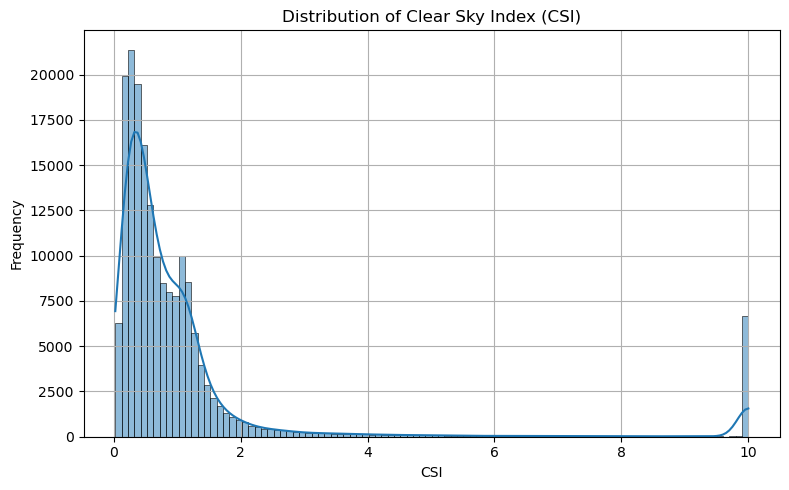

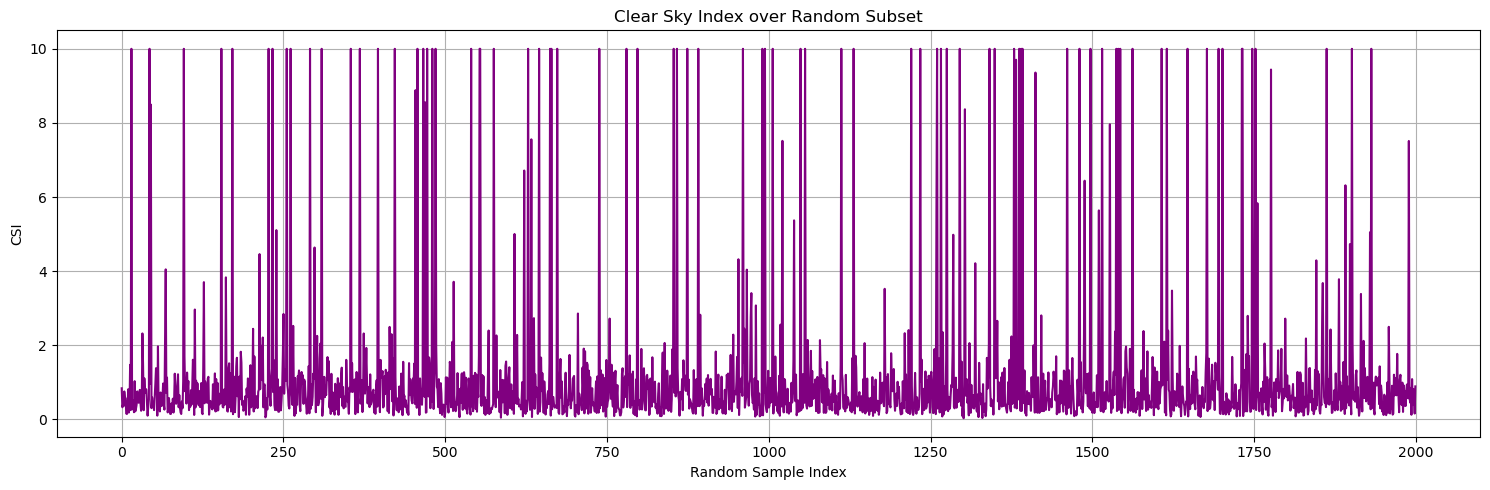

In [71]:
# 8️⃣ Compute Clear Sky Index (CSI)
epsilon = 1e-3  # avoid division by zero
csi = ghi_measured / (ghi_clearsky + epsilon)

# Clean up potential outliers
csi = csi.clip(lower=0, upper=10).fillna(0)

# 9️⃣ Plot CSI distribution
plt.figure(figsize=(8, 5))
sns.histplot(csi, bins=100, kde=True)
plt.title("Distribution of Clear Sky Index (CSI)")
plt.xlabel("CSI")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

# 🔟 Plot CSI time series on random subset
plt.figure(figsize=(15, 5))
csi_sample = csi.iloc[plot_sample].values
plt.plot(csi_sample, lw=1.5, color='purple')
plt.title("Clear Sky Index over Random Subset")
plt.xlabel("Random Sample Index")
plt.ylabel("CSI")
plt.grid(True)
plt.tight_layout()
plt.show()


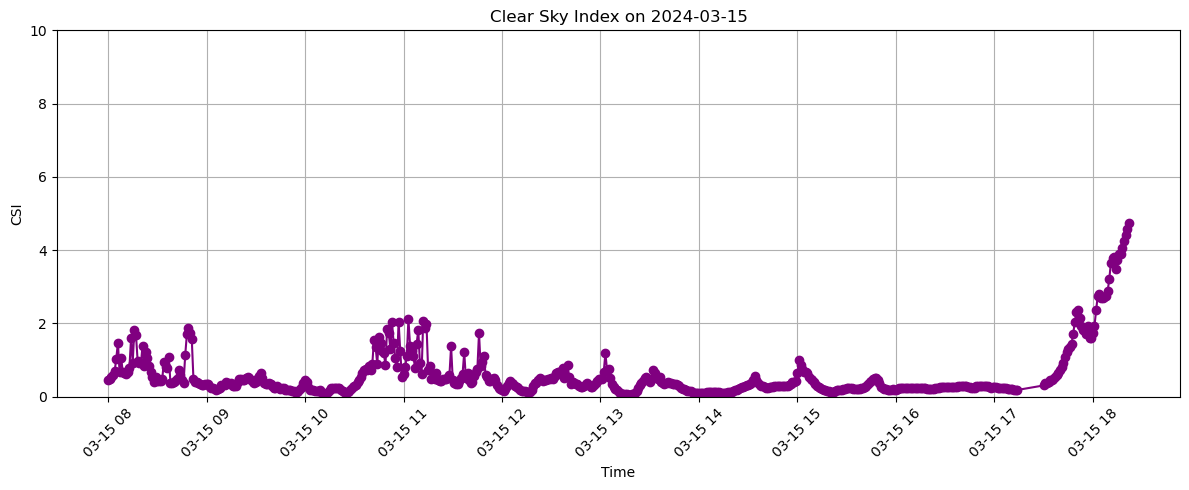

In [72]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pvlib

# 1️⃣ Ensure datetime column is datetime type
test_df['dt_UTC01_NoDLS'] = pd.to_datetime(test_df['dt_UTC01_NoDLS'])

# 2️⃣ Extract spectral columns
spectral_columns = [
    col for col in test_df.columns 
    if col.replace('.', '', 1).isdigit() and 300 <= float(col) <= 1100
]

# 3️⃣ Filter only for date 2024-08-21
selected_day = pd.Timestamp('2024-03-15')
day_df = test_df[test_df['dt_UTC01_NoDLS'].dt.date == selected_day.date()].copy()

# 4️⃣ Compute GHI from spectra
ghi_from_spectra = day_df[spectral_columns].sum(axis=1) / 1000  # W/m²

# 5️⃣ Compute clearsky using pvlib
lat, lon, tz = 51.44623, 5.48505, 'Europe/Amsterdam'
location = pvlib.location.Location(latitude=lat, longitude=lon, tz=tz)

# Localize times
times = pd.DatetimeIndex(day_df['dt_UTC01_NoDLS'])
if times.tz is None:
    times = times.tz_localize(tz)
else:
    times = times.tz_convert(tz)

# Compute clearsky
clearsky = location.get_clearsky(times, model='ineichen')
ghi_clearsky = clearsky['ghi'].reindex(times).values  \
# 6️⃣ Compute CSI
epsilon = 1e-3
csi = ghi_from_spectra.values / (ghi_clearsky + epsilon)
csi = np.clip(csi, 0, 10)

# 7️⃣ Build dataframe
plot_df = pd.DataFrame({
    'Datetime': times,
    'GHI_measured': ghi_from_spectra.values,
    'GHI_clearsky': ghi_clearsky,
    'CSI': csi
})

# 8️⃣ Filter for 08:00 - 22:00
plot_df = plot_df[(plot_df['Datetime'].dt.hour >= 8) & (plot_df['Datetime'].dt.hour <= 22)]

# 9️⃣ Plot
plt.figure(figsize=(12, 5))
plt.plot(plot_df['Datetime'], plot_df['CSI'], marker='o', linestyle='-', color='purple')
plt.title("Clear Sky Index on 2024-03-15")
plt.xlabel("Time")
plt.ylabel("CSI")
plt.ylim(0, 10)
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
